In [1]:
import itertools
import json
import operator
import os
from pathlib import Path
from pprint import pprint
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

## Load data and preprocess

### Metadata

In [2]:
# Map from test suite tag to high-level circuit.
circuits = {
    "Licensing": ["npi", "reflexive"],
    "Long-Distance Dependencies": ["fgd", "cleft"],
    "Agreement": ["number"],
    "Garden-Path Effects": ["npz", "mvrr"],
    "Gross Syntactic State": ["subordination"],
    "Center Embedding": ["center"],
}

tag_to_circuit = {tag: circuit
                  for circuit, tags in circuits.items()
                  for tag in tags}

In [3]:
# Map codenames to readable names for various columns.
def format_pretrained(model_name):
    return "%s$^*$" % model_name

PRETTY_COLUMN_MAPS = [
    ("model_name",
     {
        "vanilla": "LSTM",
        "ordered-neurons": "ON-LSTM",
        "rnng": "RNNG",
        "ngram": "n-gram",
        "random": "Random",
         
        "gpt-2-pretrained": format_pretrained("GPT-2"),
        "gpt-2-xl-pretrained": format_pretrained("GPT-2-XL"),
        "gpt-2": "GPT-2",
        "transformer-xl": format_pretrained("Transformer-XL"),
        "grnn": format_pretrained("GRNN"),
        "jrnn": format_pretrained("JRNN"),
    }),
    
    ("corpus", lambda x: x.upper() if x else "N/A"),
]
PRETTY_COLUMNS = ["pretty_%s" % col for col, _ in PRETTY_COLUMN_MAPS]

In [4]:
# Exclusions
exclude_suite_re = re.compile(r"^fgd-embed[34]|^gardenpath|^nn-nv")
exclude_models = ["1gram", "ngram-no-rand"] # "ngram", 

In [5]:
ngram_models = ["1gram", "ngram", "ngram-single"]
baseline_models = ["random"]

# Models for which we designed a controlled training regime
controlled_models = ["ngram", "ordered-neurons", "vanilla", "rnng", "gpt-2"]
controlled_nonbpe_models = ["ngram", "ordered-neurons", "vanilla", "rnng"]

### Load

In [6]:
ppl_data_path = Path("../data/raw/perplexity.csv")
test_suite_results_path = Path("../data/raw/test_suite_results")

In [7]:
perplexity_df = pd.read_csv(ppl_data_path, index_col=["model", "corpus", "seed"])
perplexity_df.index.set_names("model_name", level=0, inplace=True)

results_df = pd.concat([pd.read_csv(f) for f in test_suite_results_path.glob("*.csv")])

# Split model_id into constituent parts
model_ids = results_df.model.str.split("_", expand=True).rename(columns={0: "model_name", 1: "corpus", 2: "seed"})
results_df = pd.concat([results_df, model_ids], axis=1).drop(columns=["model"])
results_df["seed"] = results_df.seed.fillna("0").astype(int)

# Add tags
results_df["tag"] = results_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
results_df["circuit"] = results_df.tag.map(tag_to_circuit)
tags_missing_circuit = set(results_df.tag.unique()) - set(tag_to_circuit.keys())
if tags_missing_circuit:
    print("Tags missing circuit: ", ", ".join(tags_missing_circuit))

Tags missing circuit:  nn


In [8]:
# Exclude test suites
exclude_filter = results_df.suite.str.contains(exclude_suite_re)
print("Dropping %i results / %i suites due to exclusions:"
      % (exclude_filter.sum(), len(results_df[exclude_filter].suite.unique())))
print(" ".join(results_df[exclude_filter].suite.unique()))
results_df = results_df[~exclude_filter]

# Exclude models
exclude_filter = results_df.model_name.isin(exclude_models)
print("Dropping %i results due to dropping models:" % exclude_filter.sum(), list(results_df[exclude_filter].model_name.unique()))
results_df = results_df[~exclude_filter]

# Exclude word-level controlled models with BPE tokenization
exclude_filter = (results_df.model_name.isin(controlled_nonbpe_models)) & (results_df.corpus.str.endswith("bpe"))
results_df = results_df[~exclude_filter]

# Exclude GPT-2 with word-level or SentencePieceBPE tokenization
exclude_filter = ((results_df.model_name=="gpt-2") & ~(results_df.corpus.str.endswith("gptbpe")))
results_df = results_df[~exclude_filter]

Dropping 55083 results / 3 suites due to exclusions:
nn-nv-rpl fgd-embed3 fgd-embed4
Dropping 6392 results due to dropping models: ['ngram-no-rand', '1gram']


In [9]:
# Average across seeds of each ngram model.
# The only difference between "seeds" of these model types are random differences in tie-breaking decisions.
for ngram_model in ngram_models:
    # Create a synthetic results_df with one ngram model, where each item is correct if more than half of
    # the ngram seeds vote.
    ngram_results_df = (results_df[results_df.model_name == ngram_model].copy()
                        .groupby(["model_name", "corpus", "suite", "item", "tag", "circuit"])
                        .agg({"correct": "mean"}) > 0.5).reset_index()
    ngram_results_df["seed"] = 0
    
    # Drop existing model results.
    results_df = pd.concat([results_df[~(results_df.model_name == ngram_model)],
                            ngram_results_df], sort=True)

In [10]:
# Prettify name columns, which we'll carry through data manipulations
for column, map_fn in PRETTY_COLUMN_MAPS:
    pretty_column = "pretty_%s" % column
    results_df[pretty_column] = results_df[column].map(map_fn)
    if results_df[pretty_column].isna().any():
        print("WARNING: In prettifying %s, yielded NaN values:" % column)
        print(results_df[results_df[pretty_column].isna()])

### Data prep

In [11]:
suites_df = results_df.groupby(["model_name", "corpus", "seed", "suite"] + PRETTY_COLUMNS).correct.mean().reset_index()
suites_df["tag"] = suites_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
suites_df["circuit"] = suites_df.tag.map(tag_to_circuit)

# For controlled evaluation:
# Compute a model's test suite accuracy relative to the mean accuracy on this test suite.
# Only compute this on controlled models.
def get_controlled_mean(suite_results):
    # When computing test suite mean, first collapse test suite accuracies within model--corpus, then combine resulting means.
    return suite_results[suite_results.model_name.isin(controlled_models)].groupby(["model_name", "corpus"]).correct.mean().mean()
suite_means = suites_df.groupby("suite").apply(get_controlled_mean)
suites_df["correct_delta"] = suites_df.apply(lambda r: r.correct - suite_means.loc[r.suite] if r.model_name in controlled_models else None, axis=1)

In [12]:
# Join PPL and accuracy data.
joined_data = suites_df.groupby(["model_name", "corpus", "seed"] + PRETTY_COLUMNS)[["correct", "correct_delta"]].agg("mean")
joined_data = pd.DataFrame(joined_data).join(perplexity_df).reset_index()
joined_data.head()

# Track BPE + size separately.
joined_data["corpus_size"] = joined_data.corpus.str.split("-").apply(lambda tokens: tokens[1] if len(tokens) >= 2 else None)
joined_data["corpus_bpe"] = joined_data.corpus.str.split("-").apply(lambda tokens: tokens[2] if len(tokens) > 2 else ("none" if len(tokens) >= 2 else None))

In [13]:
# Join PPL and accuracy data, splitting on circuit.
joined_data_circuits = suites_df.groupby(["model_name", "corpus", "seed", "circuit"] + PRETTY_COLUMNS)[["correct", "correct_delta"]].agg("mean")
joined_data_circuits = pd.DataFrame(joined_data_circuits).reset_index().set_index(["model_name", "corpus", "seed"]).join(perplexity_df).reset_index()
joined_data_circuits.head()

,model_name,corpus,seed,circuit,pretty_model_name,pretty_corpus,correct,correct_delta,pid,test_loss,test_ppl
0,gpt-2,bllip-lg-gptbpe,1581955288,Agreement,GPT-2,BLLIP-LG-GPTBPE,0.701754,0.430994,NaN,NaN,32.138346
1,gpt-2,bllip-lg-gptbpe,1581955288,Center Embedding,GPT-2,BLLIP-LG-GPTBPE,0.910714,0.313244,NaN,NaN,32.138346
2,gpt-2,bllip-lg-gptbpe,1581955288,Garden-Path Effects,GPT-2,BLLIP-LG-GPTBPE,0.855159,0.267138,NaN,NaN,32.138346
3,gpt-2,bllip-lg-gptbpe,1581955288,Gross Syntactic State,GPT-2,BLLIP-LG-GPTBPE,0.967391,0.397826,NaN,NaN,32.138346
4,gpt-2,bllip-lg-gptbpe,1581955288,Licensing,GPT-2,BLLIP-LG-GPTBPE,0.586842,0.397061,NaN,NaN,32.138346


In [14]:
# Analyze stability to modification.
def has_modifier(ts):
    if ts.endswith(("_modifier", "_mod")):
        return True
    else:
        return None
suites_df["has_modifier"] = suites_df.suite.transform(has_modifier)

# Mark "non-modifier" test suites
modifier_ts = suites_df[suites_df.has_modifier == True].suite.unique()
no_modifier_ts = [re.sub(r"_mod(ifier)?$", "", ts) for ts in modifier_ts]
suites_df.loc[suites_df.suite.isin(no_modifier_ts), "has_modifier"] = False
# Store subset of test suites which have definite modifier/no-modifier marking
suites_df_mod = suites_df[~(suites_df.has_modifier.isna())].copy()
suites_df_mod["has_modifier"] = suites_df_mod.has_modifier.astype(bool)
# Get base test suite (without modifier/no-modifier marking)
suites_df_mod["test_suite_base"] = suites_df_mod.suite.transform(lambda ts: ts.strip("_no-modifier").strip("_modifier"))
suites_df_mod.head()

,model_name,corpus,seed,suite,pretty_model_name,pretty_corpus,correct,tag,circuit,correct_delta,has_modifier,test_suite_base
0,gpt-2,bllip-lg-gptbpe,1581955288,center_embed,GPT-2,BLLIP-LG-GPTBPE,0.892857,center,Center Embedding,0.265327,False,center_emb
1,gpt-2,bllip-lg-gptbpe,1581955288,center_embed_mod,GPT-2,BLLIP-LG-GPTBPE,0.928571,center,Center Embedding,0.361161,True,center_emb
2,gpt-2,bllip-lg-gptbpe,1581955288,cleft,GPT-2,BLLIP-LG-GPTBPE,1.000000,cleft,Long-Distance Dependencies,0.218333,False,cleft
3,gpt-2,bllip-lg-gptbpe,1581955288,cleft_modifier,GPT-2,BLLIP-LG-GPTBPE,0.775000,cleft,Long-Distance Dependencies,0.297500,True,cleft
8,gpt-2,bllip-lg-gptbpe,1581955288,mvrr,GPT-2,BLLIP-LG-GPTBPE,0.714286,mvrr,Garden-Path Effects,0.156696,False,v


### Checks

In [15]:
# Each model--corpus--seed should have perplexity data.
ids_from_results = results_df.set_index(["model_name", "corpus", "seed"]).sort_index().index
ids_from_ppl = perplexity_df.sort_index().index
diff = set(ids_from_results) - set(ids_from_ppl)
if diff:
    print("Missing perplexity results for:")
    pprint(diff)
    #raise ValueError("Each model--corpus--seed must have perplexity data.")

Missing perplexity results for:
{('gpt-2-pretrained', '', 0),
 ('gpt-2-xl-pretrained', '', 0),
 ('grnn', '', 0),
 ('jrnn', '', 0),
 ('random', '', 1),
 ('random', '', 2),
 ('random', '', 3),
 ('random', '', 4),
 ('random', '', 5),
 ('random', '', 6),
 ('random', '', 7),
 ('random', '', 8),
 ('random', '', 9),
 ('random', '', 10),
 ('random', '', 11),
 ('random', '', 12),
 ('random', '', 13),
 ('random', '', 14),
 ('random', '', 15),
 ('random', '', 16),
 ('random', '', 17),
 ('random', '', 18),
 ('random', '', 19),
 ('random', '', 20),
 ('random', '', 21),
 ('random', '', 22),
 ('random', '', 23),
 ('random', '', 24),
 ('random', '', 25),
 ('random', '', 26),
 ('random', '', 27),
 ('random', '', 28),
 ('random', '', 29),
 ('random', '', 30),
 ('random', '', 31),
 ('random', '', 32),
 ('random', '', 33),
 ('random', '', 34),
 ('random', '', 35),
 ('random', '', 36),
 ('random', '', 37),
 ('random', '', 38),
 ('random', '', 39),
 ('random', '', 40),
 ('random', '', 41),
 ('random', '', 4

In [16]:
# Every model--corpus--seed should have results for all test suite items.
item_list = {model_key: set(results.suite)
             for model_key, results in results_df.groupby(["model_name", "corpus", "seed"])}
not_shared = set()
for k1, k2 in itertools.combinations(item_list.keys(), 2):
    l1, l2 = item_list[k1], item_list[k2]
    if l1 != l2:
        print("SyntaxGym test suite results for %s and %s don't match" % (k1, k2))
        print("\tIn %s but not in %s:\n\t\t%s" % (k2, k1, l2 - l1))
        print("\tIn %s but not in %s:\n\t\t%s" % (k1, k2, l1 - l2))
        print()
        
        not_shared |= l2 - l1
        not_shared |= l1 - l2

if len(not_shared) > 0:
    to_drop = results_df[results_df.suite.isin(not_shared)]
    print("Dropping these test suites (%i rows) for now. Yikes:" % len(to_drop))
    print(not_shared)
    results_df = results_df[~results_df.suite.isin(not_shared)]
else:
    print("OK")

OK


In [17]:
# Second sanity check: same number of results per model--corpus--seed
result_counts = results_df.groupby(["model_name", "corpus", "seed"]).item.count()
if len(result_counts.unique()) > 1:
    print("WARNING: Some model--corpus--seed combinations have more result rows in results_df than others.")
    print(result_counts)

model_name  corpus           seed      
gpt-2       bllip-lg-gptbpe  1581955288     799
            bllip-md-gptbpe  1581861474     799
                             1582126320     799
            bllip-sm-gptbpe  1581807578     799
            bllip-xs-gptbpe  1581807512     799
                                           ... 
vanilla     bllip-sm         120           1598
                             922           1598
            bllip-xs         111           1598
                             120           1598
                             922           1598
Name: item, Length: 1046, dtype: int64


In [18]:
# Second sanity check: same number of suite-level results per model--corpus--seed
suite_result_counts = suites_df.groupby(["model_name", "corpus", "seed"]).suite.count()
if len(suite_result_counts.unique()) > 1:
    print("WARNING: Some model--corpus--seed combinations have more result rows in suites_df than others.")
    print(suite_result_counts)

## Prepare for data rendering

In [19]:
RENDER_FINAL = True
figure_path = Path("../reports/camera_ready_figures")
figure_path.mkdir(exist_ok=True, parents=True)

RENDER_CONTEXT = {
    "font_scale": 3.5,
    "rc": {"lines.linewidth": 2.5, "hatch.linewidth":3},
    "style": "ticks",
    "font": "Liberation Sans"
}
sns.set(**RENDER_CONTEXT)

In [20]:
BASELINE_LINESTYLE = {
    "color": "gray",
    "linestyle": "--",
}
CORPUS_MARKERS = {
    "BLLIP-LG": "s",
    "BLLIP-MD": "v",
    "BLLIP-SM": "P",
    "BLLIP-XS": "X",
    
    "BLLIP-LG-BPE": "s",
    "BLLIP-MD-BPE": "v",

    "BLLIP-LG-GPTBPE": "s",
    "BLLIP-MD-GPTBPE": "v",
    "BLLIP-SM-GPTBPE": "P",
    "BLLIP-XS-GPTBPE": "X"
}
p = sns.color_palette()[:len(joined_data.model_name.unique())]
MODEL_COLORS = {
    "GPT-2": p[0],
    "LSTM": p[1],
    "ON-LSTM": p[2],
    "RNNG": p[3],
    "n-gram": p[4],
    "Random": "darkgrey",
         
    format_pretrained("GPT-2"): "mediumturquoise",
    format_pretrained("GPT-2-XL"): p[5],
    format_pretrained("Transformer-XL"): "gold",
    format_pretrained("GRNN"): p[6],
    format_pretrained("JRNN"):  "deeppink",
}

In [21]:
def render_final(path):
    sns.despine()
    plt.tight_layout()
    plt.savefig(path)

In [22]:
# Standardize axis labels
SG_ABSOLUTE_LABEL = "SG score"
SG_DELTA_LABEL = "SG score delta"
PERPLEXITY_LABEL = "Test perplexity"

In [23]:
# Establish consistent orderings of model names, corpus names, circuit names
# for figure ordering / coloring. (NB these refer to prettified names)
model_order = sorted(set(results_df.pretty_model_name))
controlled_model_order = sorted(set(results_df[results_df.model_name.isin(controlled_models)].pretty_model_name))
corpus_order = ["BLLIP-LG", "BLLIP-MD", "BLLIP-SM", "BLLIP-XS",
                "BLLIP-LG-BPE", "BLLIP-LG-GPTBPE", 
                "BLLIP-MD-GPTBPE", "BLLIP-SM-GPTBPE", "BLLIP-XS-GPTBPE"]
nobpe_corpus_order = [c for c in corpus_order if "BPE" not in c]
circuit_order = sorted([c for c in results_df.circuit.dropna().unique()])

## Reproducing paper figures

### Figure 1 (Basic barplot)

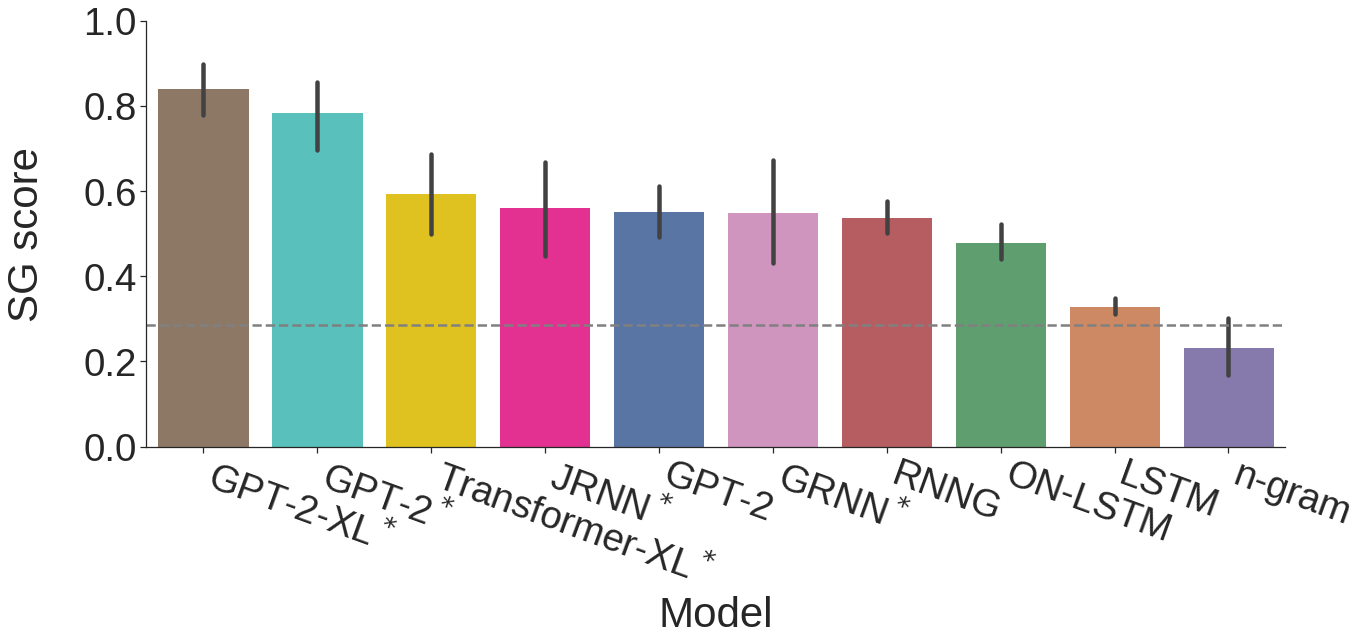

In [24]:
f, ax = plt.subplots(figsize=(20, 10))

# Exclude random baseline; will plot as horizontal line
plot_df = suites_df[(suites_df.model_name != "random")]

# Sort by decreasing average accuracy
order = list(plot_df.groupby("pretty_model_name").correct.mean().sort_values(ascending=False).index)

sns.barplot(data=plot_df.reset_index(), x="pretty_model_name", y="correct", order=order, ax=ax, palette=MODEL_COLORS)

# Plot random chance baseline
ax.axhline(suites_df[suites_df.model_name == "random"].correct.mean(), **BASELINE_LINESTYLE)

# Adjust labels and axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=340, horizontalalignment="left")
ax.set_ylim(0,1)
plt.xlabel("Model")
plt.ylabel(SG_ABSOLUTE_LABEL, labelpad=36)

if RENDER_FINAL:
    render_final(figure_path / "overall.pdf")

### Controlled evaluation of model type + dataset size

In [25]:
controlled_suites_df = suites_df[suites_df.model_name.isin(controlled_models)]
controlled_suites_df_mod = suites_df_mod[suites_df_mod.model_name.isin(controlled_models)]
controlled_joined_data_circuits = joined_data_circuits[joined_data_circuits.model_name.isin(controlled_models)]

### Figure 3

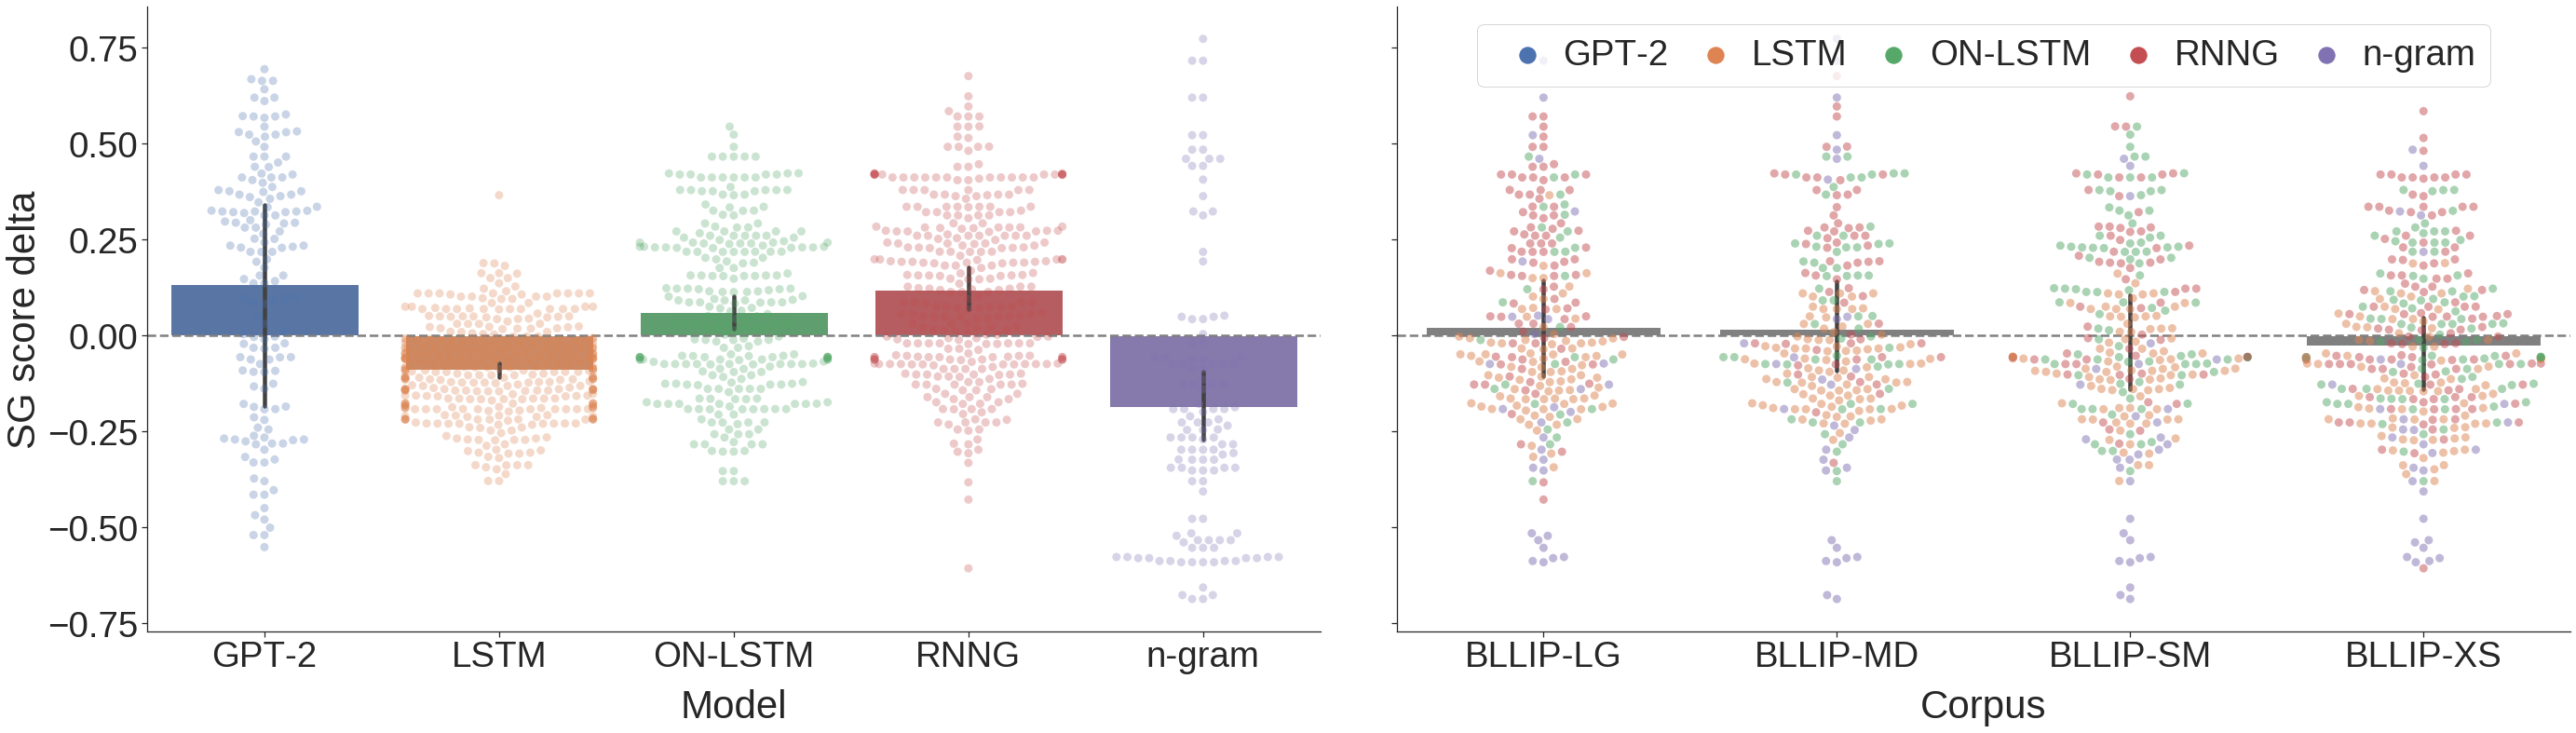

In [26]:
_, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(40,12))
for i, ax in enumerate(axes):
    ax.axhline(0, c="gray", linestyle="--")
    if i == 0:
        kwargs = dict(data=controlled_suites_df.reset_index(), order=controlled_model_order, ax=ax,
                      x="pretty_model_name", y="correct_delta", palette=MODEL_COLORS)
        sns.barplot(**kwargs, units="corpus")
        sns.swarmplot(**kwargs, alpha=0.3, size=9)

        ax.set_xlabel("Model", labelpad=16)
        ax.set_ylabel(SG_DELTA_LABEL)
    elif i == 1:
        # Estimate error intervals with a structured bootstrap: resampling units = model
        kwargs = dict(data=controlled_suites_df.reset_index(), x="pretty_corpus", y="correct_delta", order=nobpe_corpus_order, ax=ax)
        sns.barplot(**kwargs, color="Gray", units="pretty_model_name")
        sns.swarmplot(**kwargs, hue="pretty_model_name",  hue_order=controlled_model_order, palette=MODEL_COLORS, size=9, alpha=0.5)

        handles, labels = ax.get_legend_handles_labels()
        for h in handles:
            h.set_sizes([300.0])

        ax.set_xlabel("Corpus", labelpad=16)
        ax.set_ylabel("")
        ax.legend(handles, labels, loc="upper center", ncol=5, columnspacing=0.3, handletextpad=0.01)

if RENDER_FINAL:
    render_final(figure_path / "controlled.pdf")

### Figure 4

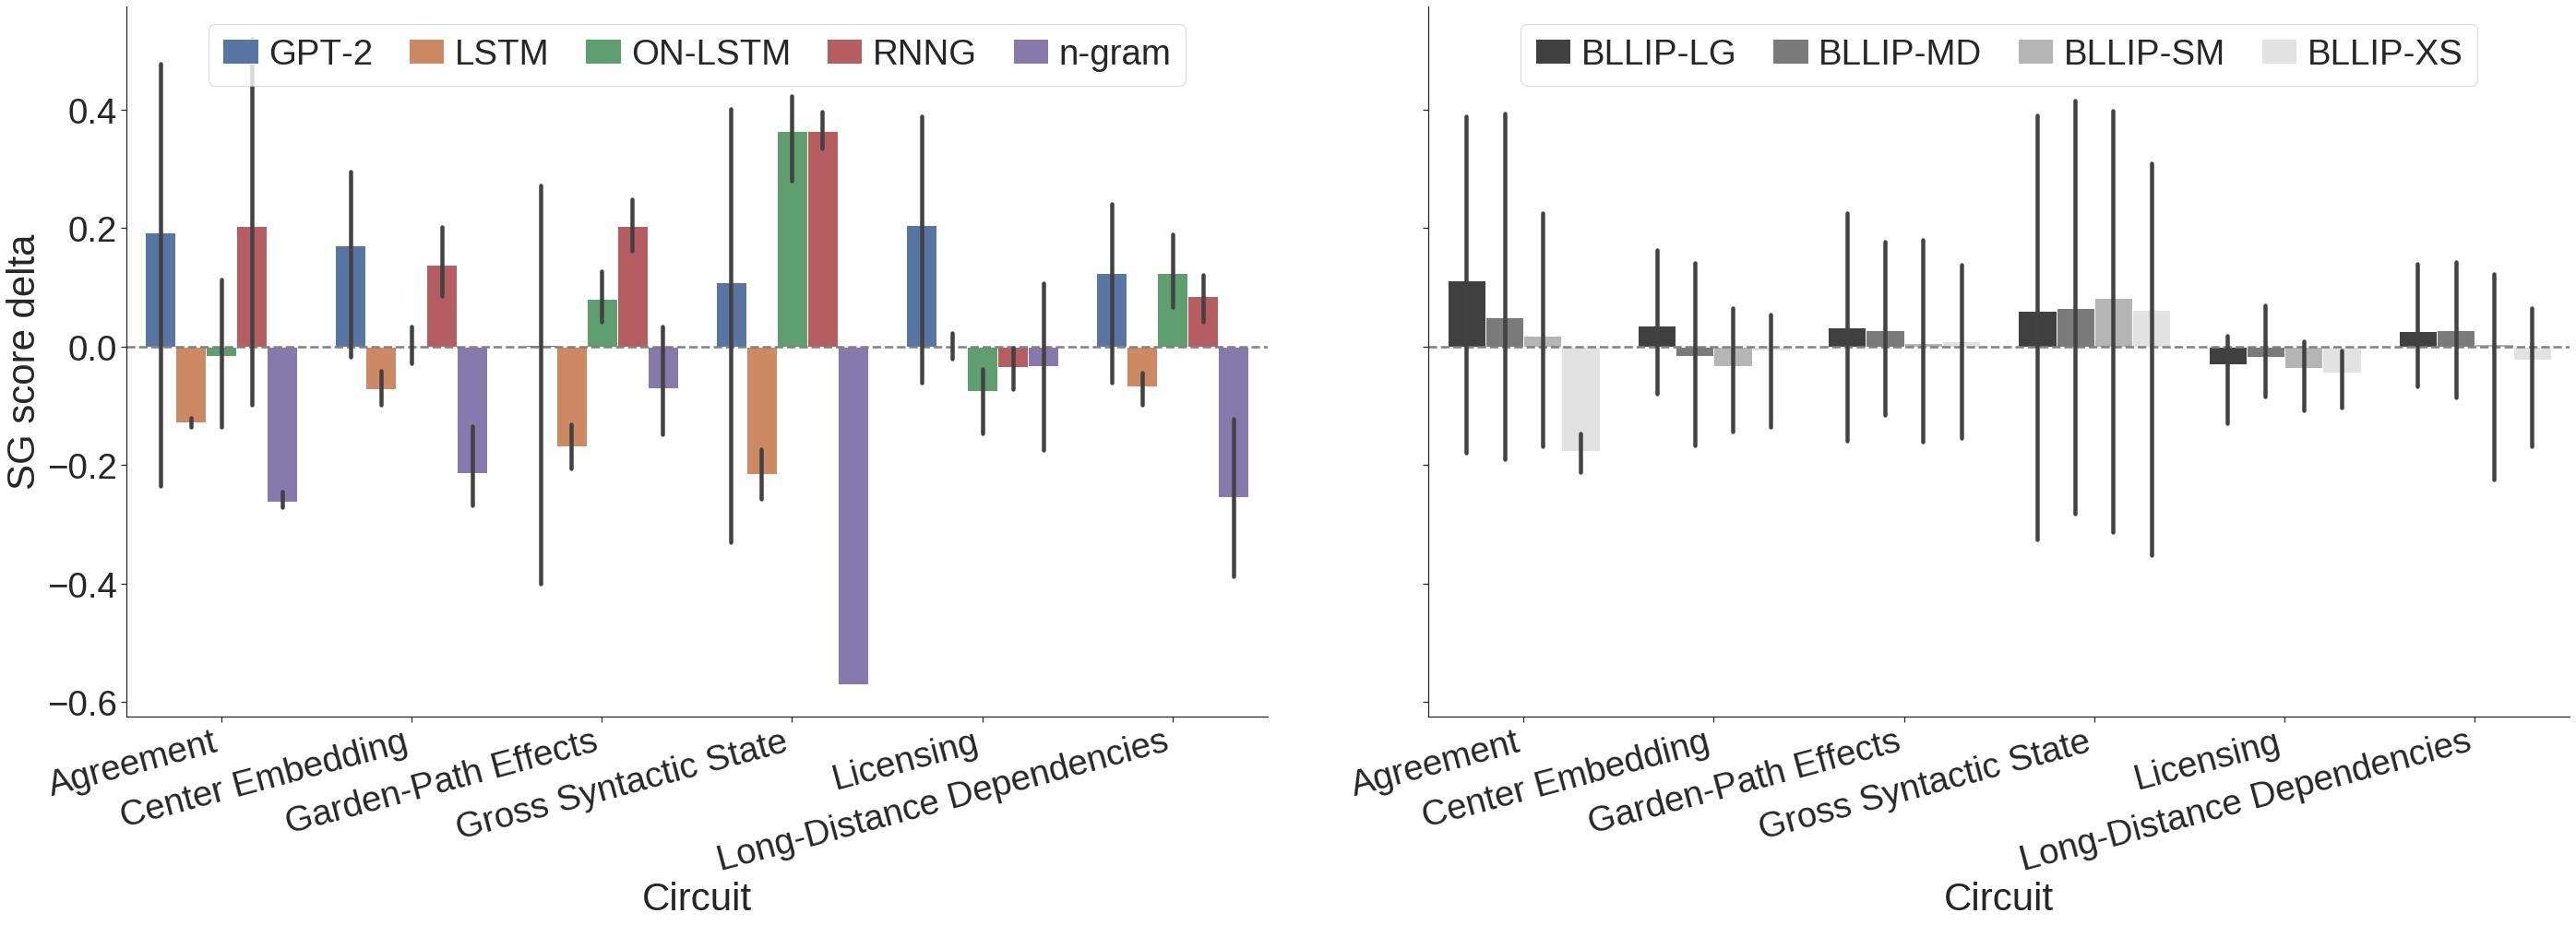

In [27]:
_, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(40,15))
legend_params=dict(title="", ncol=5, loc="upper center", columnspacing=1, handlelength=1, handletextpad=0.3)

for i, ax in enumerate(axes):
    ax.axhline(0, **BASELINE_LINESTYLE)
    if i == 0:
        sns.barplot(data=controlled_joined_data_circuits, x="circuit", y="correct_delta",
                    hue="pretty_model_name", units="corpus", hue_order=controlled_model_order,
                    ax=ax, palette=MODEL_COLORS)
        ax.set_ylabel(SG_DELTA_LABEL)
    elif i == 1:
        sns.barplot(data=controlled_joined_data_circuits, x="circuit", y="correct_delta",
                    hue="pretty_corpus", units="model_name", hue_order=nobpe_corpus_order,
                    ax=ax, palette="Greys_r")
        ax.set_ylabel("")
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
    ax.set_xlabel("Circuit")
    ax.legend(**legend_params)

if RENDER_FINAL:
    render_final(figure_path / "controlled_circuit.pdf")

### Figure 5

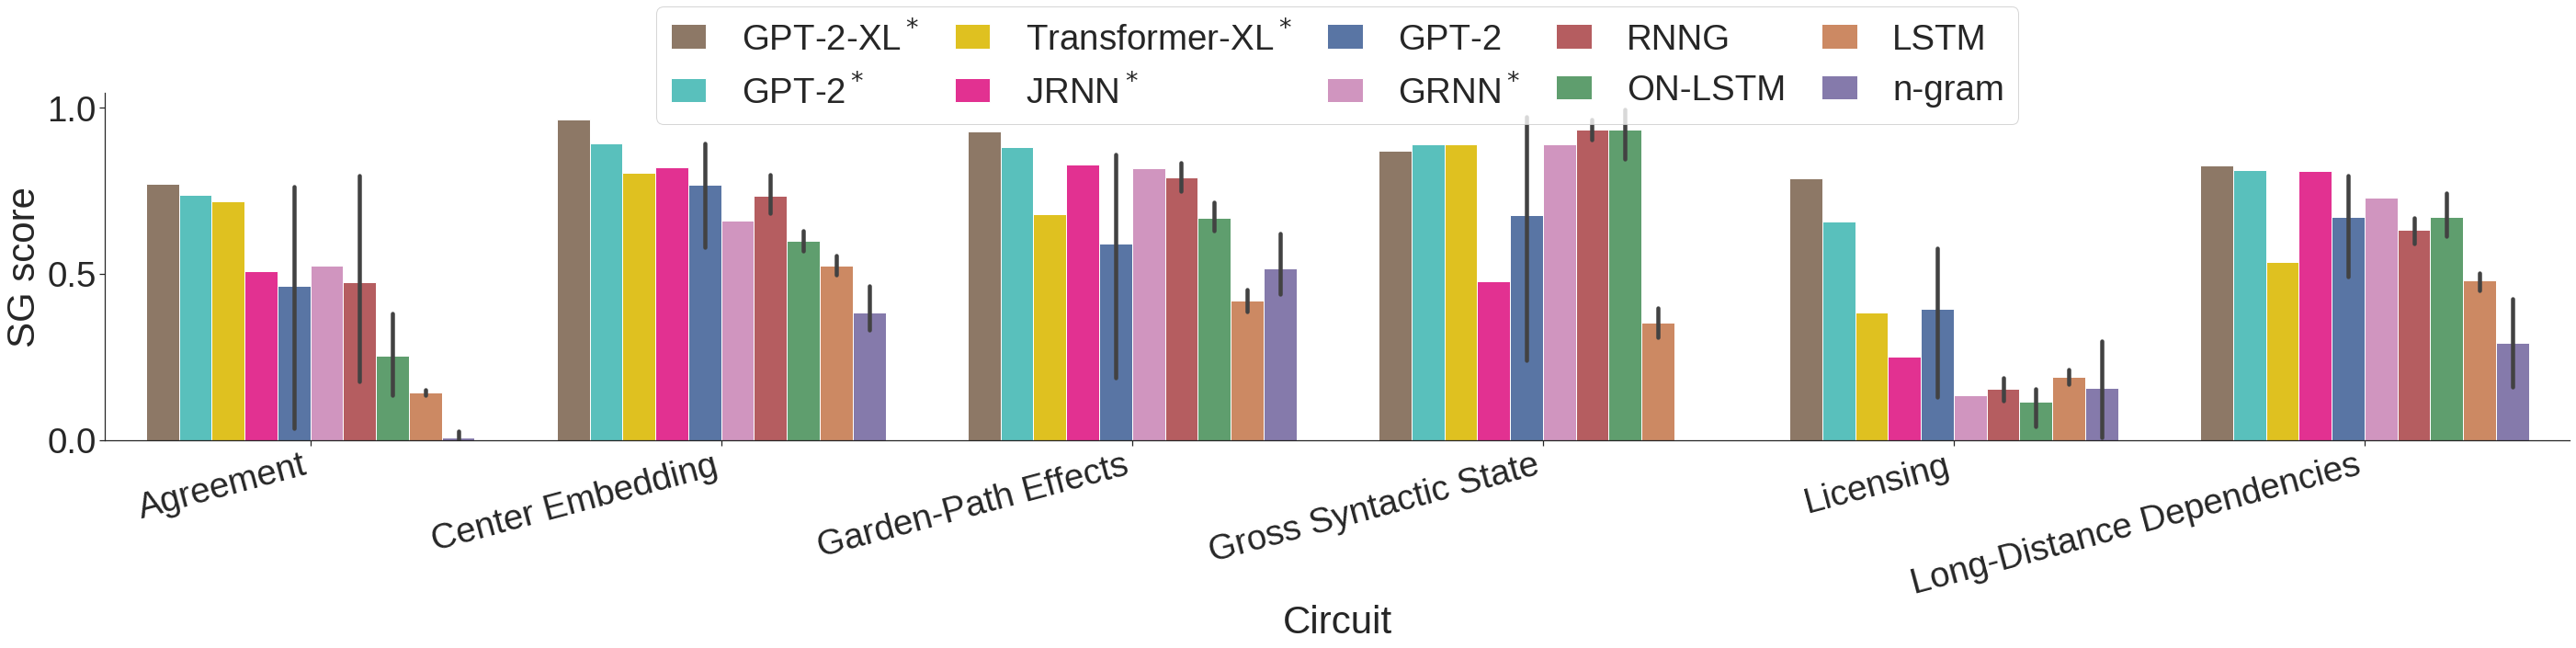

In [28]:
_, ax = plt.subplots(figsize=(40,12))
joined_data_circuits_norandom = joined_data_circuits[joined_data_circuits.pretty_model_name != "Random"]
order = list(plot_df.groupby("pretty_model_name").correct.mean().sort_values(ascending=False).index)
sns.barplot(data=joined_data_circuits_norandom, x="circuit", y="correct",
            hue="pretty_model_name", units="corpus", hue_order=order, ax=ax, palette=MODEL_COLORS)

ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
ax.set_xlabel("Circuit")
ax.set_ylabel(SG_ABSOLUTE_LABEL)
ax.legend(title="", ncol=int(len(order)/2), loc="upper center", columnspacing=1, handlelength=1, handletextpad=1, bbox_to_anchor=(0.5,1.3))

if RENDER_FINAL:
    render_final(figure_path / "allmodels_circuit.pdf")

### Figure 6 (Stability to modification)

In [29]:
print("Suites in modification analysis:", controlled_suites_df_mod.suite.unique())

Suites in modification analysis: ['center_embed' 'center_embed_mod' 'cleft' 'cleft_modifier' 'mvrr'
 'mvrr_mod' 'npz_ambig' 'npz_ambig_mod' 'npz_obj' 'npz_obj_mod']


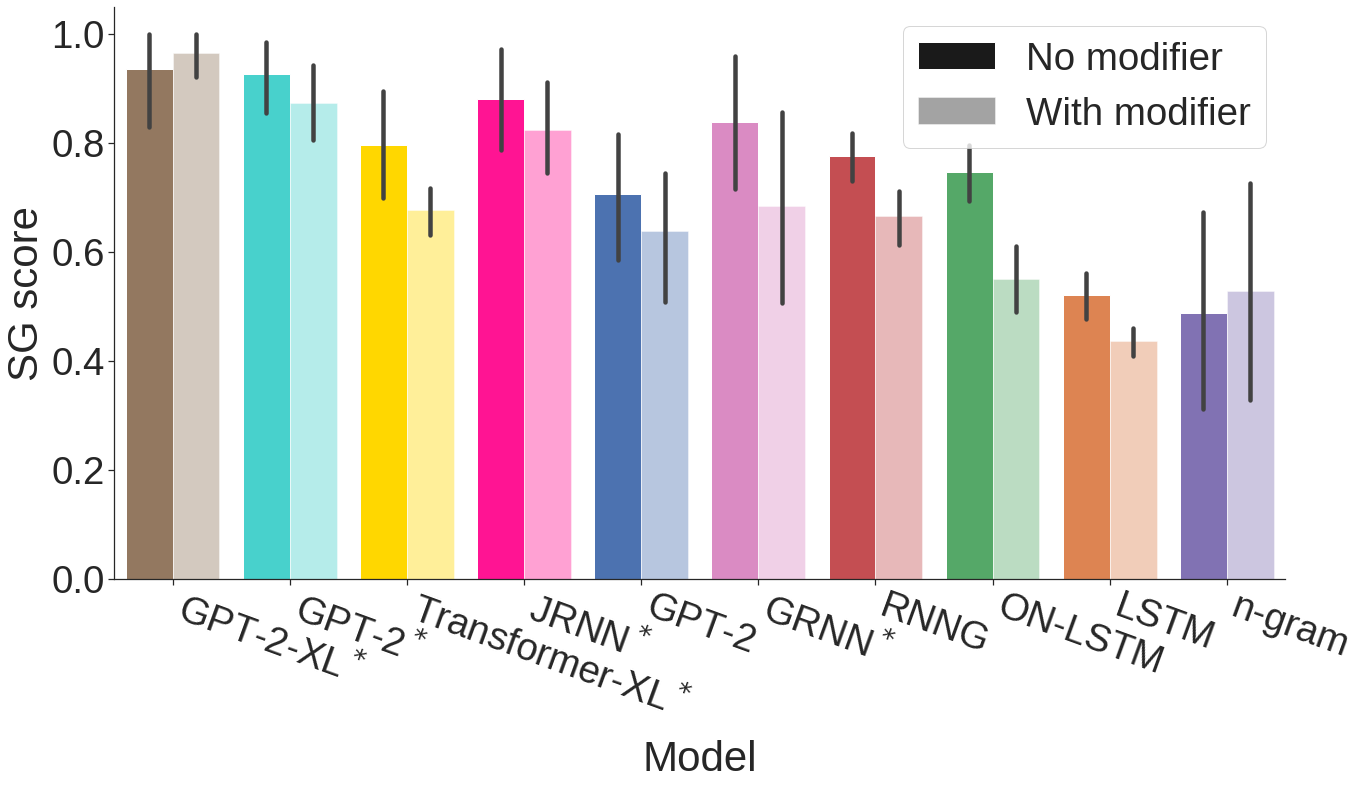

In [31]:
# Sort by decreasing average accuracy.
order = list(plot_df.groupby("pretty_model_name").correct.mean().sort_values(ascending=False).index)

_, ax = plt.subplots(figsize=(20,12))
sns.barplot(data=suites_df_mod, x="pretty_model_name", y="correct", hue="has_modifier", order=order, ax=ax)

# Colors.
sorted_patches = sorted(ax.patches, key=lambda bar: bar.get_x())
colors = [MODEL_COLORS[order[i]] for i in range(len(order))]
for i, bar in enumerate(sorted_patches):
    bar.set_facecolor(colors[int(i/2)])
    if i % 2 != 0:
        bar.set_alpha(0.4)

# Set labels.
ax.set_xlabel("Model", labelpad=16)
ax.set_ylabel(SG_ABSOLUTE_LABEL)
ax.set_xticklabels(ax.get_xticklabels(), rotation=340, horizontalalignment="left")

# Custom legend.
handles, _ = ax.get_legend_handles_labels()
handles[0] = mpatches.Patch(facecolor="k")
handles[1] = mpatches.Patch(facecolor="k", alpha=0.4)
ax.legend(handles, ["No modifier", "With modifier"], loc="upper right", title="")

if RENDER_FINAL:
    render_final(figure_path / "stability-all-models.pdf")

### Figure 2 (SG score vs perplexity)

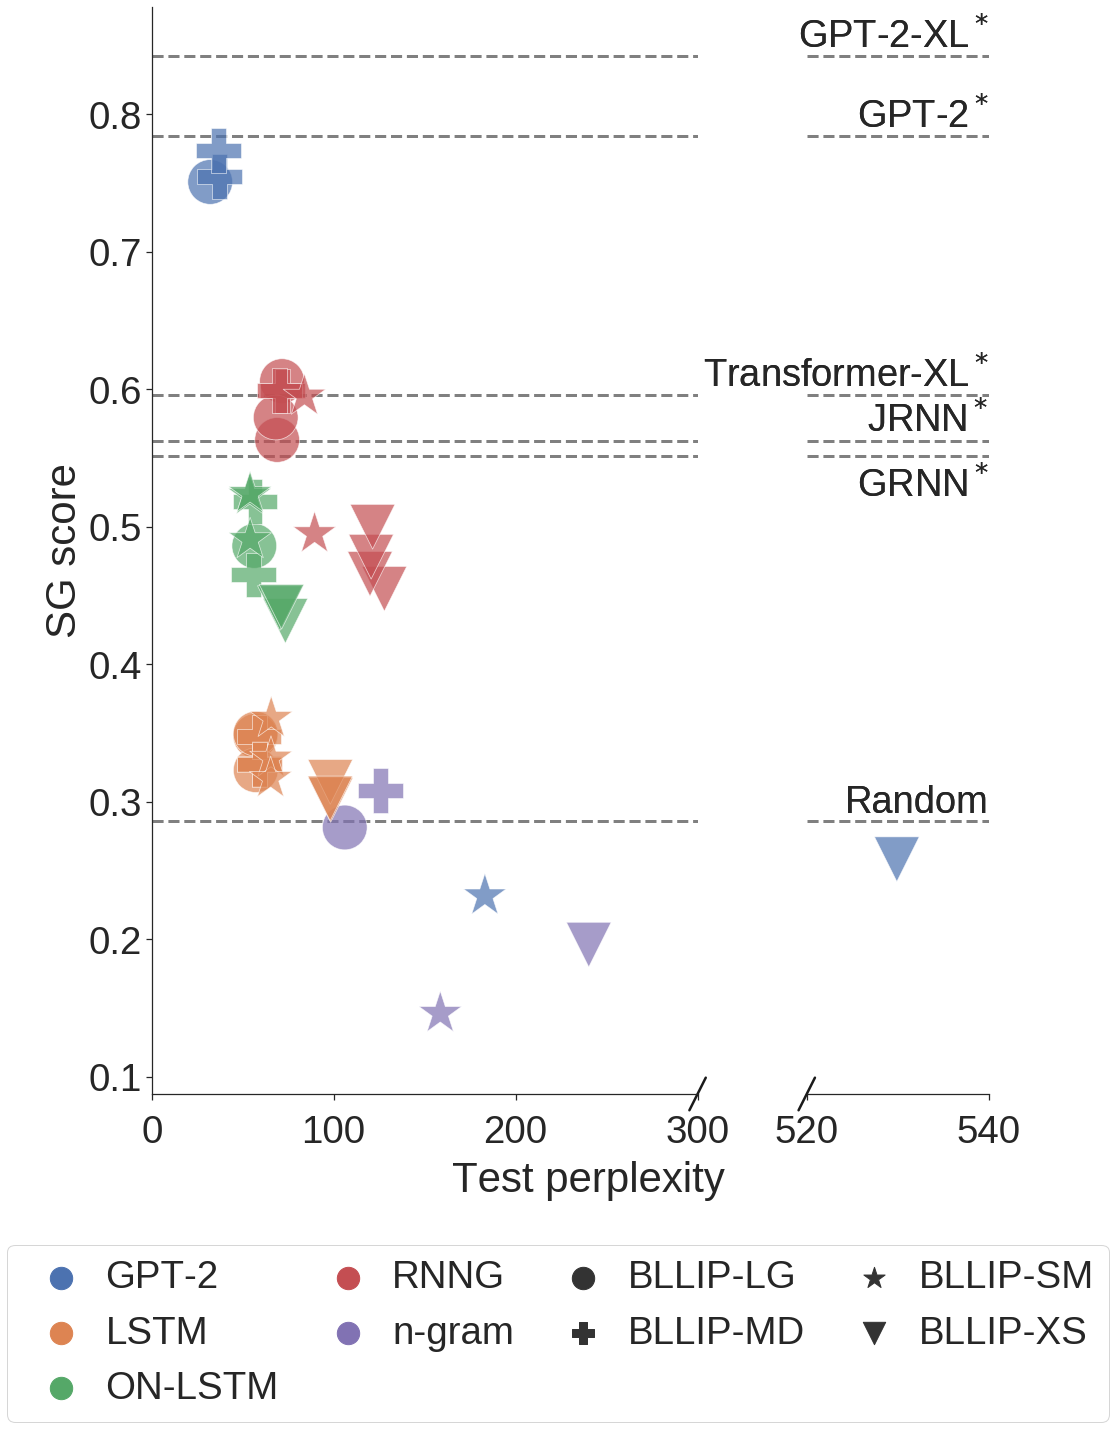

In [33]:
ax_ratio = 3
f, (ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(15, 20),gridspec_kw={'width_ratios': [ax_ratio, 1]})

sns.despine()

for ax in [ax1,ax2]:
    sns.scatterplot(data=joined_data, x="test_ppl", y="correct", hue="pretty_model_name", 
                    hue_order=model_order, palette=MODEL_COLORS, markers=["o", "P", "*", "v"],
                    s=2000, style="corpus_size", ax=ax, zorder=2, alpha=0.7)
    ax.set_xlabel("")
    ax.tick_params(axis='x', which='major', pad=15)

    # Add horizontal lines for models without ppl estimates.
    no_ppl_data = joined_data[joined_data.test_ppl.isna()]
    for model_name, rows in no_ppl_data.groupby("pretty_model_name"):
        y = rows.correct.mean()
        ax.axhline(y, zorder=1, linewidth=3, **BASELINE_LINESTYLE) 
        if "GRNN" in model_name: # custom spacing tweaking
            y_offset = -0.03
        else:
            y_offset = 0.006
        ax2.text(540, y + y_offset, model_name, fontdict={"size": 38}, ha='right')
    
plt.subplots_adjust(wspace=0.3)
ax1.get_legend().remove()
ax1.set_ylabel(SG_ABSOLUTE_LABEL)
ax2.set_ylabel("")
plt.xlabel(PERPLEXITY_LABEL, labelpad=10, position=(-1.2,0))

# Add break in x-axis
ax1.set_xlim(0,300)
ax2.set_xlim(520,540)
# hide the spines between ax1 and ax2
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_ticks([])
d = .015 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the right subplot
ax2.plot((-d*ax_ratio,+d*ax_ratio), (-d,+d), **kwargs)
    
# Change some legend labels.
handles, labels = ax1.get_legend_handles_labels()
legend_title_map = {"pretty_model_name": "Model",
                    "pretty_corpus": "Corpus",
                    "corpus_size": "Corpus size",
                    "corpus_bpe": "Tokenization"}
# Re-map some labels.
# labels = [legend_title_map.get(l, l) for l in labels]
drop_indices = [i for i,l in enumerate(labels) if l in legend_title_map.keys() or l in no_ppl_data.pretty_model_name.values]
handles = [h for i,h in enumerate(handles) if i not in drop_indices]
labels = [l for i,l in enumerate(labels) if i not in drop_indices]
labels = [l if l not in joined_data.corpus_size.unique() else "BLLIP-%s" % l.upper() for l in labels]
for l, h in zip(labels, handles):
    h.set_sizes([500.0])
plt.legend(handles, labels, bbox_to_anchor=(-4.5,-0.22), ncol=4, loc="center left", columnspacing=0.8, handletextpad=0.15)

if RENDER_FINAL:
    # Can't use render_final function because of some spine issues.
    plt.savefig(figure_path / "perplexity.pdf", bbox_inches="tight")



## Appendix B: Circuit–circuit correlations

In [34]:
# Exclude some models from circuit correlation analysis.
EXCLUDE_FROM_CIRCUIT_ANALYSIS = ["random", "ngram", "1gram", "ngram-single"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  del sys.path[0]


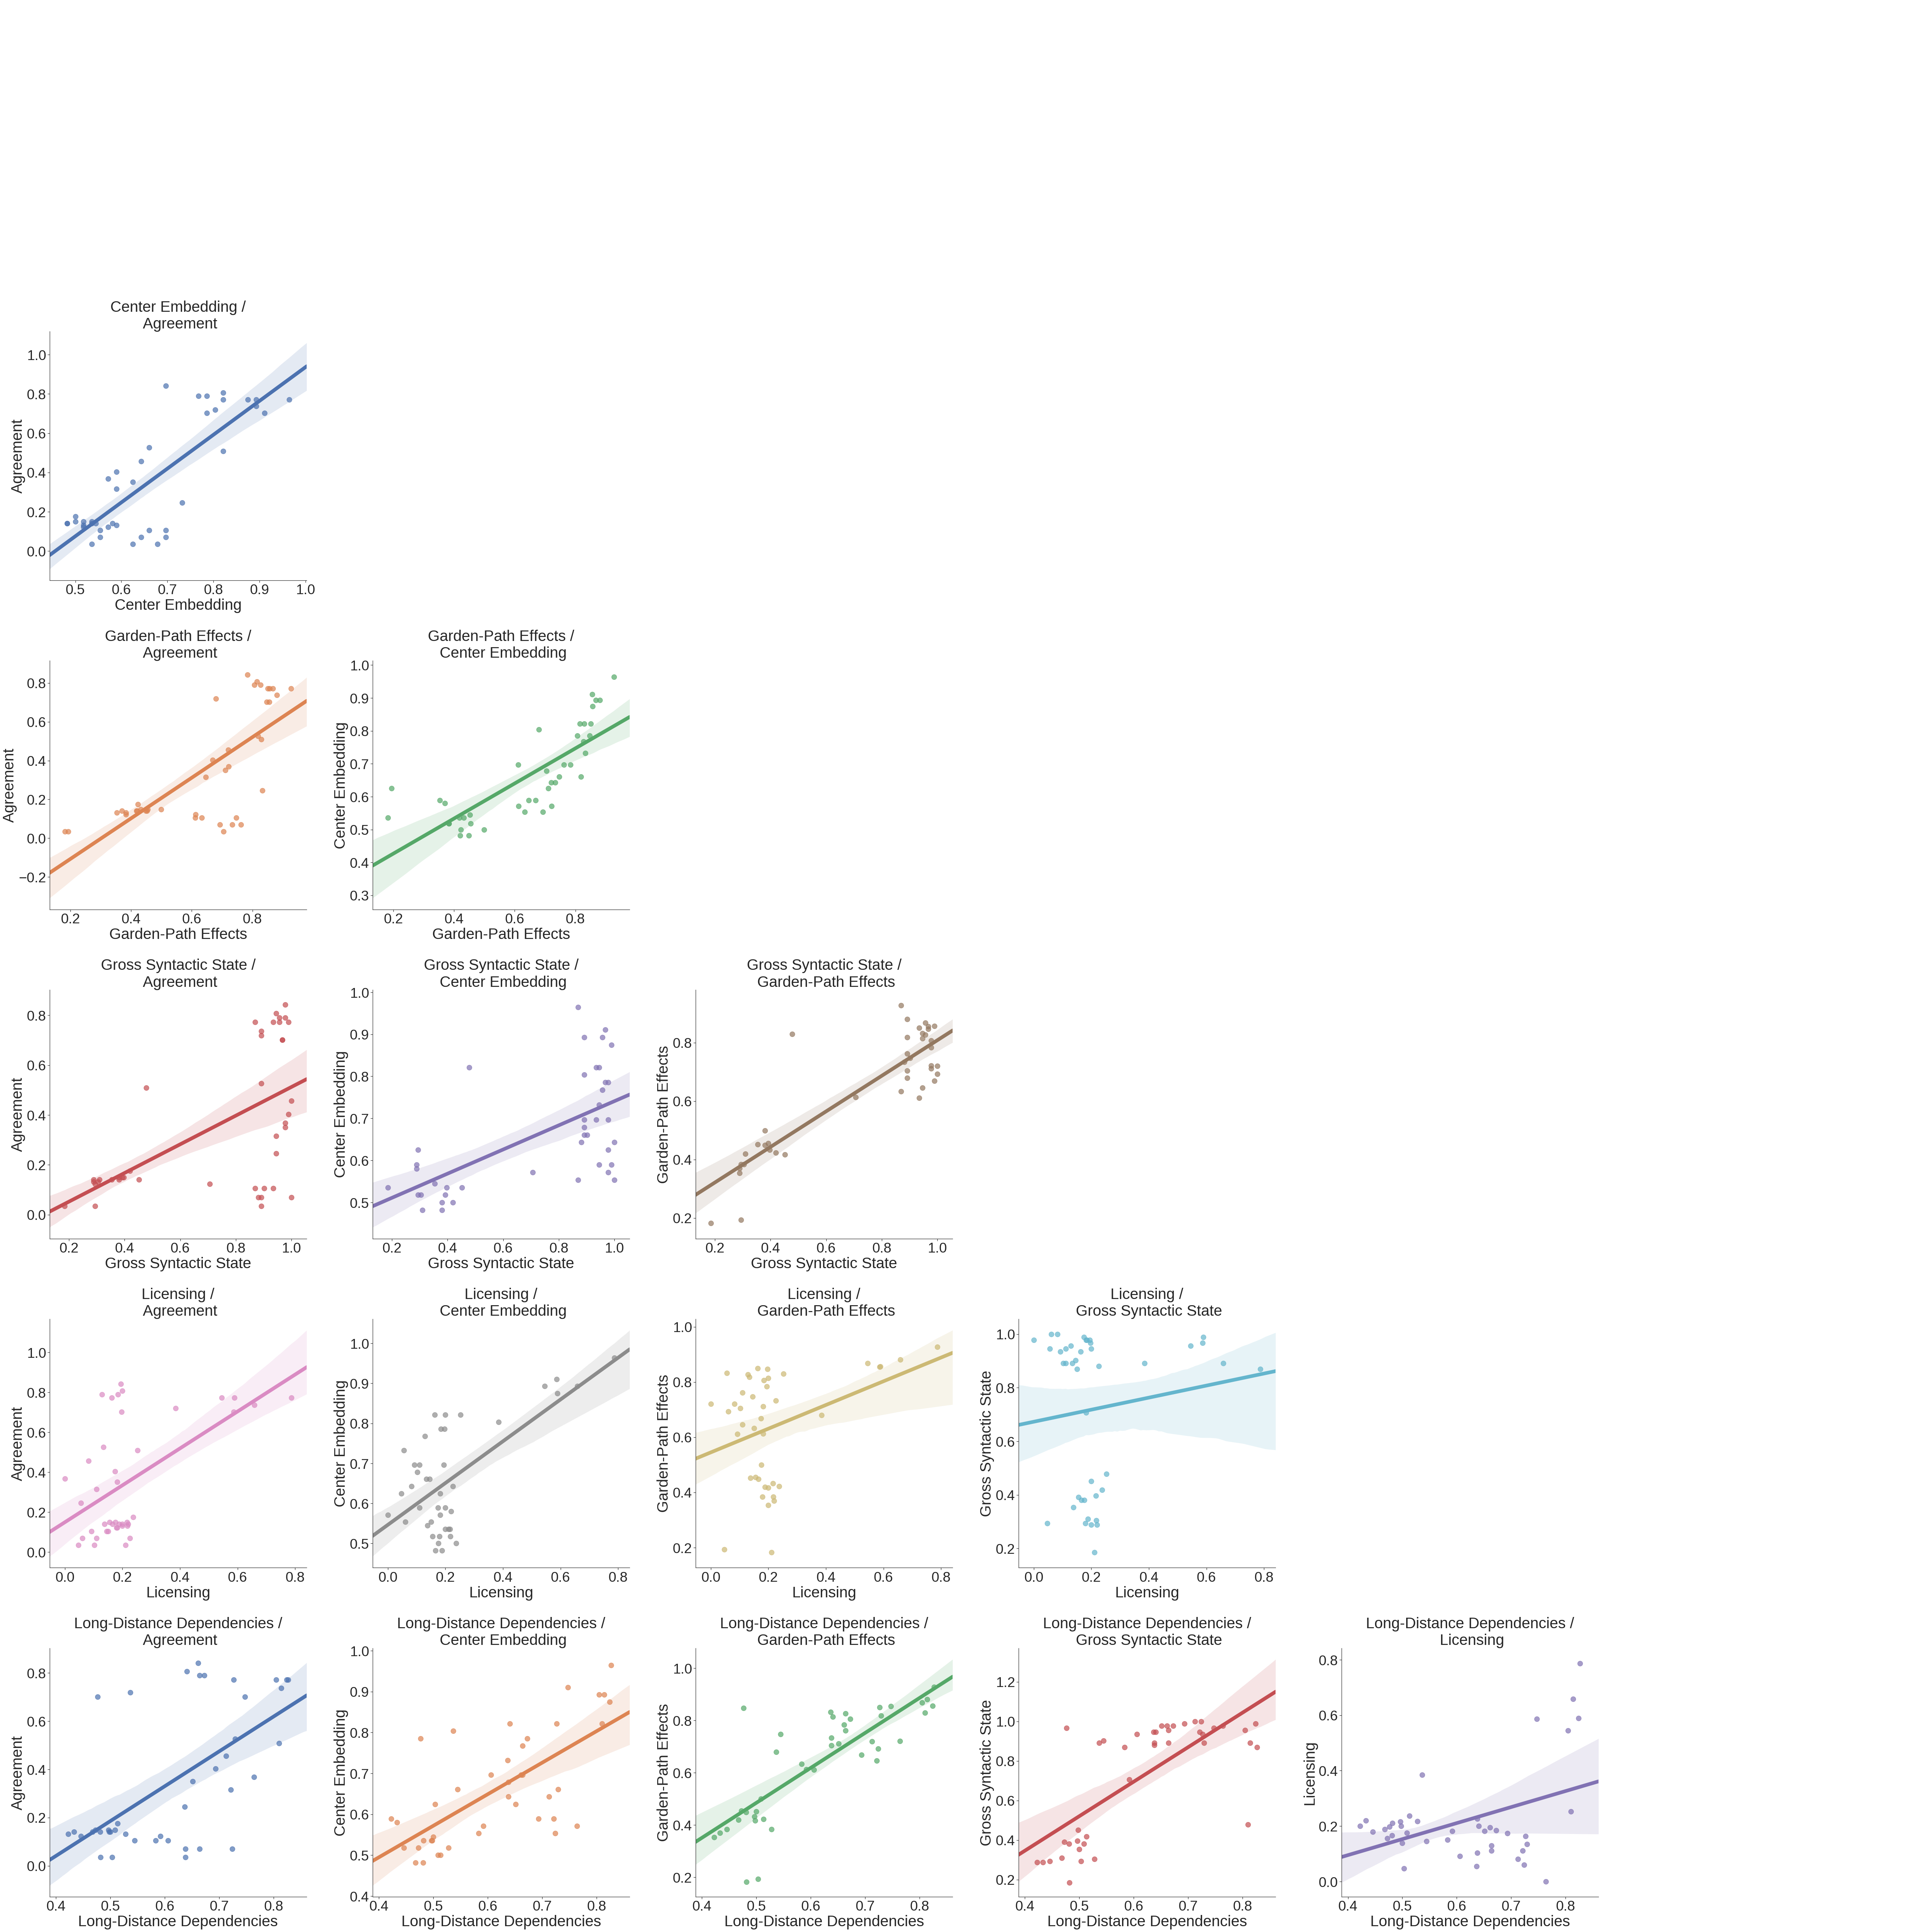

In [35]:
f, axs = plt.subplots(len(circuit_order), len(circuit_order), figsize=(75, 75))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

source_df = suites_df[~suites_df.model_name.isin(EXCLUDE_FROM_CIRCUIT_ANALYSIS)]

for c1, row in zip(circuit_order, axs):
    for c2, ax in zip(circuit_order, row):
        if c1 <= c2:
            ax.axis("off")
            continue
            
        xs = source_df[source_df.circuit == c1].groupby(["model_name", "corpus", "seed"]).correct.agg({c1: "mean"})
        ys = source_df[source_df.circuit == c2].groupby(["model_name", "corpus", "seed"]).correct.agg({c2: "mean"})
        df = pd.concat([xs, ys], axis=1)
        ax.set_title("%s /\n %s" % (c1, c2))
        sns.regplot(data=df, x=c1, y=c2, ax=ax, line_kws=dict(linewidth=10), scatter_kws=dict(s=200, alpha=0.7))
        
if RENDER_FINAL:
    render_final(figure_path / "all-correlations.pdf")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # This is added back by InteractiveShellApp.init_path()


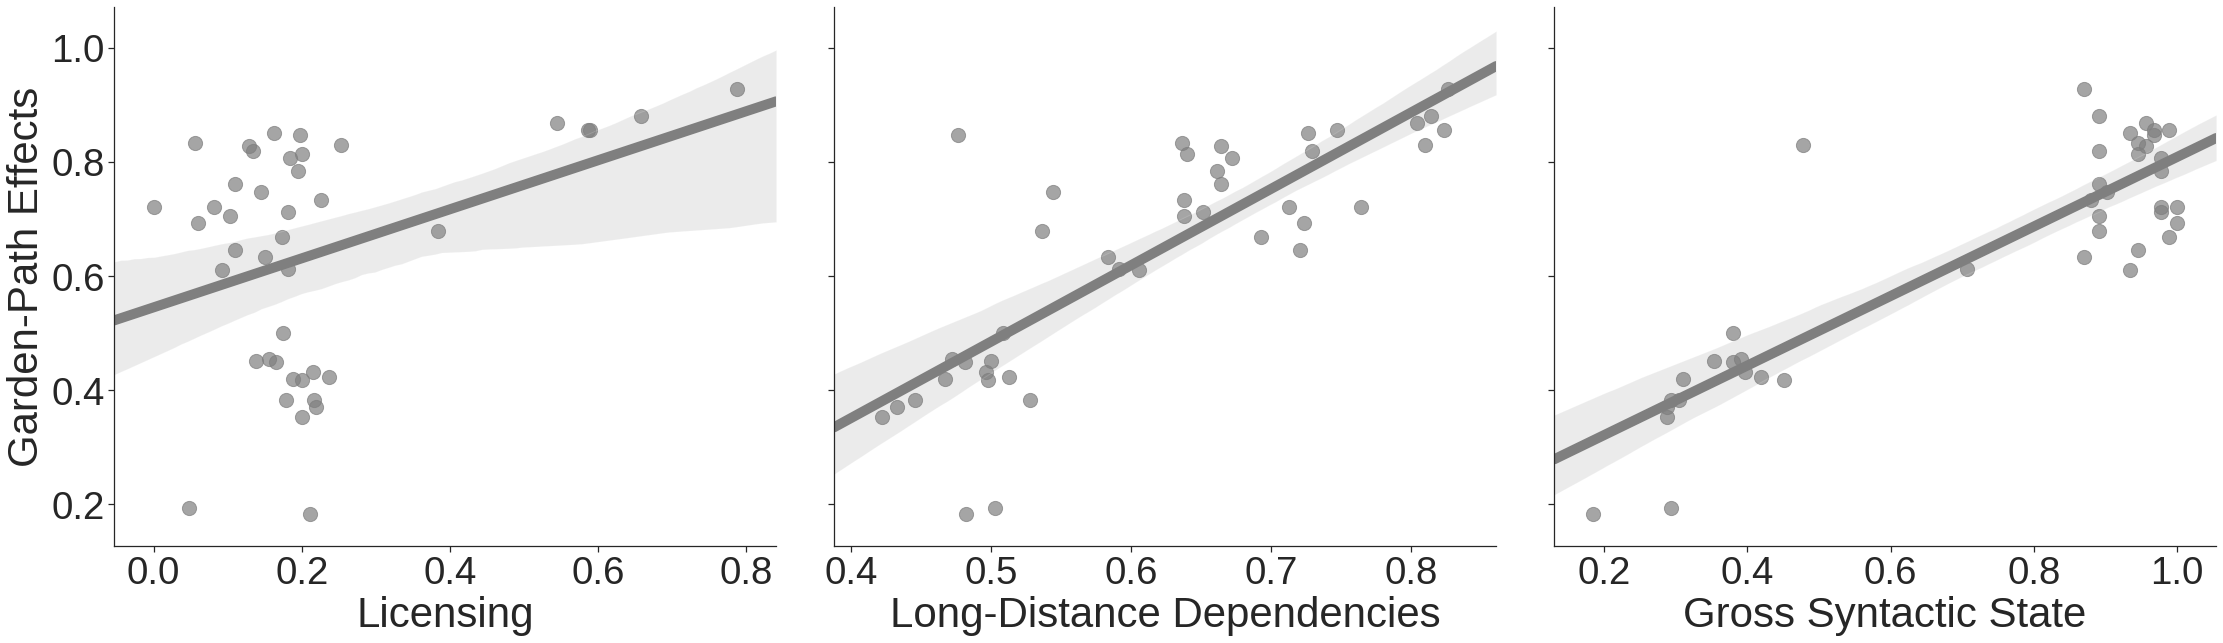

In [36]:
f, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(32,10))
plt.subplots_adjust(wspace=0.1)

source_df = suites_df[~suites_df.model_name.isin(EXCLUDE_FROM_CIRCUIT_ANALYSIS)]

cy = "Garden-Path Effects"
cxs = ["Licensing", "Long-Distance Dependencies", "Gross Syntactic State"]
for i, ax in enumerate(axes):
    cx = cxs[i]
    xs = source_df[source_df.circuit == cx].groupby(["model_name", "corpus", "seed"]).correct.agg({cx: "mean"})
    ys = source_df[source_df.circuit == cy].groupby(["model_name", "corpus", "seed"]).correct.agg({cy: "mean"})
    df = pd.concat([xs, ys], axis=1)
    sns.regplot(data=df, x=cx, y=cy, ax=ax, color="tab:grey",
                line_kws=dict(linewidth=10), scatter_kws=dict(s=200, alpha=0.7))
    if i > 0:
        ax.set_ylabel("")
        
if RENDER_FINAL:
    render_final(figure_path / "correlations.pdf")